In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url = "https://cve.mitre.org/data/downloads/allitems.csv"
df = pd.read_csv(url, encoding='iso8859_15', header=None, skiprows=10)
df.columns = ['Name', 'Status', 'Description', 'References', 'Phase', 'Votes', 'Comments']

/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,Name,Status,Description,References,Phase,Votes,Comments
0,CVE-1999-0001,Candidate,ip_input.c in BSD-derived TCP/IP implementatio...,BUGTRAQ:19981223 Re: CERT Advisory CA-98.13 - ...,Modified (20051217),"MODIFY(1) Frech | NOOP(2) Northcutt, W...",Christey> A Bugtraq posting indicates that the...
1,CVE-1999-0002,Entry,Buffer overflow in NFS mountd gives root acces...,BID:121 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
2,CVE-1999-0003,Entry,Execute commands as root via buffer overflow i...,BID:122 | URL:http://www.securityfocus.com...,NaN,NaN,NaN
3,CVE-1999-0004,Candidate,"MIME buffer overflow in email clients, e.g. So...",CERT:CA-98.10.mime_buffer_overflows | MS:M...,Modified (19990621),"ACCEPT(8) Baker, Cole, Collins, Dik, Landfi...","Frech> Extremely minor, but I believe e-mail i..."
4,CVE-1999-0005,Entry,Arbitrary command execution via IMAP buffer ov...,BID:130 | URL:http://www.securityfocus.com...,NaN,NaN,NaN


In [4]:
df = df[~df.Description.str.startswith('**')]
df = df[~df.Name.str.contains('2022')]
df = df.set_axis(range(df.shape[0]), axis=0)

In [5]:
desc = df['Description'].str.lower()
desc[0:3]

0    ip_input.c in bsd-derived tcp/ip implementatio...
1    buffer overflow in nfs mountd gives root acces...
2    execute commands as root via buffer overflow i...
Name: Description, dtype: object

In [6]:
from string import digits
desc1 = ['']
remove_digits = str.maketrans("","",digits)
for line in desc:
     desc1.append(line.translate(remove_digits))

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import string

In [8]:
stop_words = stopwords.words('english')

def remove_stop_words(text):
    words = text.split(' ')
    text1 = " ".join([i for i in words if i not in stop_words])
    return text1

In [9]:
def clean_entry(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation + string.digits}
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)

    return text1

In [10]:
desc1 = desc.apply(remove_stop_words)
desc1 = desc1.apply(clean_entry)

In [11]:
all_stop_words = gensim.parsing.preprocessing.STOPWORDS

def remove_all_stop_words(text):
    words = text.split(' ')
    text1 = " ".join([i for i in words if i not in all_stop_words])
    return text1

In [12]:
desc2 = desc1.apply(remove_all_stop_words)
desc2[0]

'ipinputc bsdderived tcpip implementations allows remote attackers cause denial service crash hang crafted packets'

In [13]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

desc3 = []
for line in desc2:
    tokens = word_tokenize(line)
    lemma_function = WordNetLemmatizer()
    desc3.append([lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]) 

In [14]:
desc3[0]

['ipinputc',
 'bsdderived',
 'tcpip',
 'implementation',
 'allow',
 'remote',
 'attacker',
 'cause',
 'denial',
 'service',
 'crash',
 'hang',
 'craft',
 'packet']

In [15]:
vocab = gensim.corpora.Dictionary(desc3)
doc_word_matrix = [vocab.doc2bow(doc) for doc in desc3]
test_bow = doc_word_matrix[0]
print(test_bow)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [16]:
LDA = gensim.models.ldamodel.LdaModel

In [96]:
tops = 20
lda_model = LDA(corpus=doc_word_matrix, id2word=vocab, num_topics=20)

In [95]:
lda_model.print_topic(99)

'0.332*"flaw" + 0.126*"dos" + 0.116*"follow" + 0.086*"return" + 0.047*"vulnerability" + 0.040*"notification" + 0.039*"unsafe" + 0.034*"double" + 0.032*"ioctl" + 0.014*"sent"'

In [19]:
lda_model.get_document_topics(test_bow)

[(0, 0.51660526), (1, 0.41415837)]

In [20]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, doc_word_matrix, vocab)


/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/willnunn/opt/anaconda3/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.024828  0.214537       1        1  9.214859
2      0.087110 -0.189588       2        1  7.170098
19    -0.000373 -0.015056       3        1  6.817383
12    -0.248735 -0.047630       4        1  6.510303
17     0.014997  0.268600       5        1  6.242428
0     -0.046891  0.100282       6        1  6.197313
7      0.129055  0.228367       7        1  5.647572
8     -0.134275 -0.053658       8        1  5.529371
15    -0.096836 -0.109466       9        1  4.916061
9     -0.109975 -0.121290      10        1  4.760746
16    -0.053522  0.119760      11        1  4.601958
13    -0.176108  0.009900      12        1  4.565085
6     -0.127326 -0.029564      13        1  4.384255
1     -0.016952  0.011729      14        1  4.343132
3     -0.031643 -0.024030      15        1  3.901702
14     0.146374 -0.075550      16        1  3.555838
4      0.088102 -0.184884      17        1  3.520521
18     0.230564  0.027468      18        1  3.276753
11     0.175371 -0.016568      19        1  3.236596
10     0.195892 -0.113360      20        1  1.608024, topic_info=                Term          Freq         Total Category  logprob  loglift
68              file  57600.000000  57600.000000  Default  30.0000  30.0000
12           service  53581.000000  53581.000000  Default  29.0000  29.0000
192          version  77083.000000  77083.000000  Default  28.0000  28.0000
797              cve  41588.000000  41588.000000  Default  27.0000  27.0000
132             code  65712.000000  65712.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
856   administrative   1428.476215   2371.775590  Topic20  -3.8507   3.6231
37         execution   6333.857374  22121.656440  Topic20  -2.3614   2.8795
1045       component   4111.007519  13967.037593  Topic20  -2.7937   2.9071
395            field   2224.297846   6666.793362  Topic20  -3.4079   3.0325
1598       procedure    462.552934    818.819669  Topic20  -4.9783   3.5591

[1046 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2225      9  0.999833        able
1185     14  0.998797       abuse
1493      8  0.998786          ac
14        2  0.006419      access
14        3  0.149137      access
...     ...       ...         ...
1689     11  0.992405           y
560       6  0.889519        zero
560       8  0.109332        zero
1737     19  0.939970  zerolength
2251      4  0.997765         zip

[2100 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 20, 13, 18, 1, 8, 9, 16, 10, 17, 14, 7, 2, 4, 15, 5, 19, 12, 11])

The outcome of our LDA is interesting. Set the relevance lamba to 0.5 with the slider and examine topic one by moving your cursor over the bubble containing 1. Looking at the words, a human might think it'd be reasonable to title this topic 'buffer overflow attacks'. The unsettling thing about topic one is that it contains almost all instances of the word 'code' and gives thsse word the highest relevance score. I'd expect words like 'code' to be topic-independent, and we shall go on to test whether the inclusion of such a word is indicative of a topic model which has done a poor job. The method will incorporate the time structure of our dataset, and use change point detection. 

Plan is to run cross validated LDA to determine optimal number of topics using coherence as a performance metric. We choose the LDA which has the best performance and zone in on the topic which contains 'buffer' 'overflow'. We then carry out change point detection on the topic through the dataset and compare it with the the changepoint detection of the binary string given by zero if the document doesn't contain 'buffer overflow' and one if it does. In the buffer overflow topic there will be some words which should probably be topic-independent, we again compare the changepoint detection run on these words. Showing that the time aspect of our data set is poorly respected by our topic model.

Perhaps we could even use something temporal to inform our topic choices. Frequent (topic worthy) words are investigated, and a density estimate over time is derived for each. Words with less uniform density estimates are considered 'seed' words, and could have their weight (which weight, how?) adjusted in the LDA. Also, it can be said quite confidently that words which have fairly uniform should not be only found in one topic which contains many seed words.

What about placing each seed word into its own topic to begin with, running the Bayesian inference, and then combining any 'close' topics together?

In [21]:
pyLDAvis.disable_notebook()

# Change Point Detection

In [22]:
%pip install ruptures

Note: you may need to restart the kernel to use updated packages.


The following code is taken straight from the `ruptures` documentation

In [23]:
import ruptures as rpt
n, dim = 500, 1
n_bkps, sigma = 3, 5
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

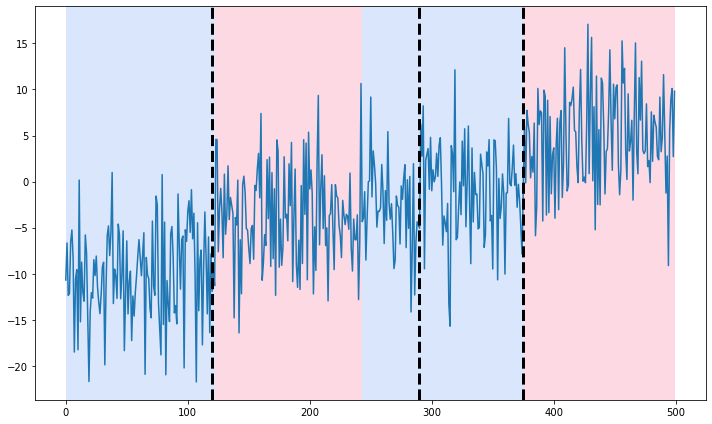

In [24]:
model = "l2"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()

The signal here is simulated, moving between background colours indicates a simulated change point, and the dashed lines are the changepoints picked up by the binary segmentation changepoint detection algorithm.

Each document has a final topic weight assigned. We retrieve this from our LDA and use this as signal data.

In [25]:
len(doc_word_matrix)

167584

Create a matrix where each row is a topic and each column is a document.

In [26]:
test = np.zeros((2,4))
print(test[0,1])

0.0


In [27]:
signal_matrix = np.zeros((tops, len(doc_word_matrix)))
len(signal_matrix[0])

167584

Now we can input our topic values for each document.

In [28]:
test_bow = doc_word_matrix[1]
print(test_bow)
test_topi = lda_model.get_document_topics(test_bow)
print(test_topi)

[(1, 1), (11, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]
[(9, 0.19896519), (12, 0.29905406), (15, 0.1066302), (17, 0.32260534)]


In [29]:
for i in range(0, len(doc_word_matrix)):
    topi = lda_model.get_document_topics(doc_word_matrix[i])
    for t in topi:
        signal_matrix[t[0], i] = t[1]

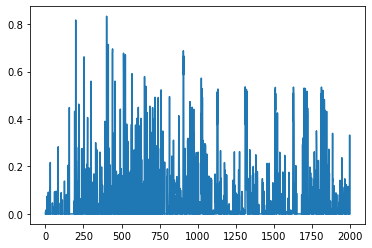

In [30]:
from random import sample
topic = 19

sorted_sample = [
    signal_matrix[topic][i] for i in sorted(sample(range(len(signal_matrix[topic])), 2000))
]

plt.plot(sorted_sample)

Realised this ^ was an idiotic approach- moving averages will be much more informative.

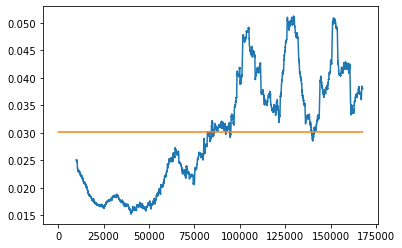

In [31]:
topic = 3

window_size = 10000

pd_series = pd.Series(signal_matrix[topic])
windows = pd_series.rolling(window_size)
moving_averages = windows.mean()
mean = pd_series.mean()

plt.plot(moving_averages)
plt.plot(np.repeat(mean, len(signal_matrix[topic])))

We see some deviation from the mean for the topic containing all instances of the word 'sql'. I want to compare that to the deviation of informative terms from the mean. If there is a noticeable difference in the signal then the Bayesian seeding might have some hope of working.

In [32]:
term = 'sql'
desc3[0:2]

[['ipinputc',
  'bsdderived',
  'tcpip',
  'implementation',
  'allow',
  'remote',
  'attacker',
  'cause',
  'denial',
  'service',
  'crash',
  'hang',
  'craft',
  'packet'],
 ['buffer',
  'overflow',
  'nfs',
  'mountd',
  'give',
  'root',
  'access',
  'remote',
  'attacker',
  'linux',
  'system']]

In [33]:
term_signal = []
for i in range(0, len(desc3)):
    if term in desc3[i]:
        term_signal.append(1)
    else:
        term_signal.append(0)

In [34]:
term_signal[0:2]

[0, 0]

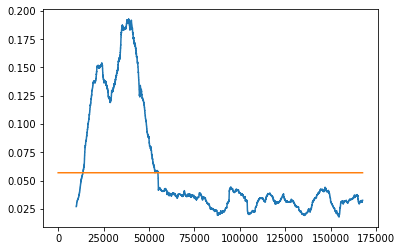

In [35]:
window_size = 10000

pd_series = pd.Series(term_signal)
windows = pd_series.rolling(window_size)
moving_averages = windows.mean()
mean = pd_series.mean()

plt.plot(moving_averages)
plt.plot(np.repeat(mean, len(signal_matrix[topic])))

This looks much more deviated from the mean than the topic containing 'sql'. One would hope that 'sql' might be the most important word for a topic- the topic containing words relating to sql injection attacks. I maintain some hope for the seeding idea!

For each potential seed term we derive the `term_signal` variable for each. The Jaccard similarity for each pair is calculated and put into a matrix, now for a k-topic model we want to find the k-clique with the largest possible weight. (This may be an NP-complete problem, and difficult to do - if this is difficult then we want to approximate. Run a greedy algorithm or something.) 

We retrieve some relevant terms a human might deem topic titles from https://www.cvedetails.com/index.php . Let's add these as lists.

In [36]:
vulns =  ["dos", "denial", "service", "code", "execution", "execute", "buffer", "overflow", "memory", "corruption", "sql", "injection",
"inject", "xss", "directory", "traversal", "bypass", "gain", "privilege", "information", "csrf", "file", "inclusion"]

In [37]:
vends = ["microsoft", "oracle", "google", "debian", "apple", "ibm", "cisco", "redhat", "canonical", "linux", "mozilla", "hp", "apache",
"sun", "adobe", "netapp"]

We'll use these terms for the Jaccard similarity if the method which extracts useful words from the time is shit.

# Using Time to Extract Topic Titles

In [97]:
vocab.token2id['allow']

0

In [39]:
vocab.id2token[0]

'allow'

In [40]:
len(vocab)

157505

`'allow'` has id `0` becasue gensims dictionary function alphabetises each document before generating ids.

In [101]:
vocab.dfs[87361]

280

In [78]:
significant_terms = []

for i in range(0, len(vocab)):
    if vocab.dfs[i] > 5000:
        significant_terms.append(vocab.id2token[i])

len(significant_terms)

114

Ok there are 114 terms appearing at least 5000 times, I would hope that meaningful 'topic titles' are included in this set. We want to find the terms which offer the largest 'signal', that is whose frequencies in time are furthest from uniform.

In [81]:
term_and_signal_max = dict()

for term in significant_terms:
    
    term_signal = []
    for i in range(0, len(desc3)):
        if term in desc3[i]:
            term_signal.append(1)
        else:
            term_signal.append(0)

    window_size = 1000
    
    pd_series = pd.Series(term_signal)
    windows = pd_series.rolling(window_size)
    moving_averages = windows.mean()
    moving_averages = moving_averages.fillna(0)

    maxi = max(moving_averages)
    mean = pd_series.mean()

    term_and_signal_max[term] = maxi/mean

In [82]:
sorted(term_and_signal_max, key=term_and_signal_max.get, reverse=True)

['plugin',
 'android',
 'ibm',
 'oracle',
 'successful',
 'cisco',
 'sensitive',
 'impact',
 'network',
 'result',
 'value',
 'obtain',
 'unauthenticated',
 'lead',
 'component',
 'handle',
 'product',
 'php',
 'exist',
 'v',
 'software',
 'http',
 'validation',
 'disclosure',
 'application',
 'execution',
 'id',
 'aka',
 'check',
 'microsoft',
 'prior',
 'certain',
 'exploit',
 'attack',
 'information',
 'send',
 'windows',
 'management',
 'server',
 'affect',
 'input',
 'data',
 'kernel',
 'url',
 'device',
 'vulnerable',
 'different',
 'x',
 'linux',
 'privilege',
 'discover',
 'contain',
 'sql',
 'process',
 'window',
 'function',
 'access',
 'gain',
 'craft',
 'malicious',
 'vector',
 'page',
 'overflow',
 'version',
 'local',
 'message',
 'earlier',
 'corruption',
 'trigger',
 'issue',
 'unknown',
 'injection',
 'security',
 'relate',
 'cve',
 'properly',
 'note',
 'unspecified',
 'control',
 'multiple',
 'crosssite',
 'parameter',
 'command',
 'read',
 'possibly',
 'inject',
 'h

The output of this is quite interesting, in some senses the processing has worked. We see that the six terms at the tail of the list are all generic, and would indeed make poor topic titles. The terms at the head of the list are more topic worthy, but perhaps too specific. Let's see if we can group these terms using Jaccard simialrity. 

Alternatively we could try a different measure for 'difference from uniform', larger p value, less ikely to be uniform.:

In [112]:
from statsmodels.tsa.stattools import adfuller

In [115]:
term_and_signal_adcf = dict()

for term in significant_terms:
    
    term_signal = []
    for i in range(0, len(desc3)):
        if term in desc3[i]:
            term_signal.append(1)
        else:
            term_signal.append(0)
    
    pd_series = pd.Series(term_signal)
   
    
    term_and_signal_adcf[term] = adfuller(pd_series)
    print(term)

allow
attacker
cause
craft
crash
denial
remote
service
access
buffer
linux
overflow
command
execute
server
arbitrary
authenticate
execution
gain
information
message
vulnerability
bypass
file
microsoft
web
window
local
user
privilege
aka
allows
function
id
x
code
parameter
process
control
obtain
sensitive
script
version
php
cisco
malicious
handle
multiple
read
earlier
attack
password
use
issue
certain
directory
device
contain
request
v
send
result
management
manager
security
possibly
data
page
url
windows
authentication
software
exploit
application
unspecified
value
http
network
kernel
memory
properly
cve
product
lead
different
vulnerable
note
component
input
trigger
check
relate
exist
oracle
ibm
plugin
html
sql
unauthenticated
inject
crosssite
successful
prior
unknown
vector
impact
corruption
validation
affect
injection
discover
disclosure
xss
android


In [117]:
sorted(term_and_signal_adcf, key=term_and_signal_adcf.get, reverse=True)

['remote',
 'allow',
 'result',
 'successful',
 'network',
 'impact',
 'arbitrary',
 'attack',
 'sensitive',
 'attacker',
 'unauthenticated',
 'obtain',
 'android',
 'execution',
 'vector',
 'version',
 'parameter',
 'lead',
 'product',
 'component',
 'id',
 'oracle',
 'access',
 'data',
 'affect',
 'unspecified',
 'http',
 'handle',
 'privilege',
 'plugin',
 'exist',
 'aka',
 'php',
 'application',
 'disclosure',
 'cisco',
 'multiple',
 'server',
 'vulnerability',
 'information',
 'execute',
 'craft',
 'issue',
 'device',
 'exploit',
 'ibm',
 'vulnerable',
 'sql',
 'check',
 'window',
 'x',
 'certain',
 'url',
 'inject',
 'value',
 'command',
 'crosssite',
 'memory',
 'cve',
 'note',
 'html',
 'local',
 'microsoft',
 'properly',
 'windows',
 'prior',
 'overflow',
 'injection',
 'discover',
 'send',
 'validation',
 'allows',
 'web',
 'xss',
 'script',
 'denial',
 'input',
 'earlier',
 'unknown',
 'gain',
 'v',
 'different',
 'service',
 'cause',
 'user',
 'malicious',
 'possibly',
 'fu

This takes a long time to run, here's the output:

In [118]:
adcf_list = ['remote','allow','result','successful','network','impact','arbitrary','attack','sensitive',
'attacker','unauthenticated','obtain','android','execution','vector','version','parameter','lead',
'product','component','id','oracle','access','data','affect','unspecified','http','handle','privilege',
'plugin','exist','aka','php','application','disclosure','cisco','multiple','server','vulnerability',
'information','execute','craft','issue','device','exploit','ibm','vulnerable','sql','check','window',
'x','certain','url','inject','value','command','crosssite','memory','cve','note','html','local',
'microsoft','properly','windows','prior','overflow','injection','discover','send','validation',
'allows','web','xss','script','denial','input','earlier','unknown','gain','v','different','service',
'cause','user','malicious','possibly','function','corruption','code','software','directory','crash',
'buffer','read','process','trigger','security','file','message','contain','page','relate','management',
'authenticate','control','kernel','use','request','password','authentication','manager','linux',
'bypass']